### Preamble

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.status()

  Activating project at `c:\Users\Marcu\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression`
  0 dependencies successfully precompiled in 7 seconds. 521 already precompiled.


Status `C:\Users\Marcu\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression\Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [479239e8] Catalyst v15.0.8
  [a93c6f00] DataFrames v1.7.0
  [0c46a032] DifferentialEquations v7.16.1
  [5b8099bc] DomainSets v0.7.15
  [a98d9a8b] Interpolations v0.16.1
  [b964fa9f] LaTeXStrings v1.4.0
  [23fbe1c1] Latexify v0.16.8
⌃ [94925ecb] MethodOfLines v0.11.8
⌅ [961ee093] ModelingToolkit v9.80.2
  [1dea7af3] OrdinaryDiffEq v6.98.0
  [b39d95ae] PhysicsInformedRegression v1.0.1 `https://github.com/MarcusGalea/PhysicsInformedRegression.jl.git#PDE_handling`
  [91a5bcdd] Plots v1.40.13
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [ ]:
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets,PhysicsInformedRegression,Plots

# Heat equation in 1D
In this notebook, we demonstrate how to solve the heat equation in one dimension using the finite difference method. We then proceed to demonstrate how to use `PhysicsInformedRegression.jl` to estimate the thermal diffusivity $\alpha$ from data.

The heat equation is a partial differential equation that describes how heat diffuses through a medium over time. In one dimension, the heat equation can be written as:
$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$
where:
- $u(t,x)$ is the temperature at time $t$ and position $x$,
- $\alpha$ is the thermal diffusivity, a material property that characterizes how quickly heat diffuses through the medium.

The finite difference method is a numerical technique used to approximate solutions to differential equations by discretizing the continuous variables. In this case, we will discretize space and solve the equations numerically as a system of ordinary differential equations (ODEs).
Given the initial condition
$$
u(0,x) = \cos(x)
$$
and the boundary conditions
$$
u(t,0) = \exp(-t), \quad u(t,1) = \exp(-t)\cos(1)
$$
we can use the finite difference method to approximate the solution to the heat equation.

In [5]:
# Method of Manufactured Solutions: exact solution
u_exact = (t,x) -> exp.(-t) * cos.(x)
du_exact = (t,x) -> [-u_exact(t,x), -exp(-t) * sin(x)]
ddu_exact = (t,x) -> [[u_exact(t,x), exp(-t) * sin(x)]; 
                      [exp(-t) * sin(x), -u_exact(t,x)]]  

# Parameters, variables, and derivatives
@parameters α
@independent_variables t x
@variables u(..)
Dt = Differential(t)
Dxx = Differential(x)^2

parameterdict = Dict(α => 1.0) # Ground truth for the parameter α


# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ α * Dxx(u(t, x))
bcs = [u(0, x) ~ cos(x),
        u(t, 0) ~ exp(-t),
        u(t, 1) ~ exp(-t) * cos(1)]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)], [α]; defaults = parameterdict)

PDESystem
Equations: Equation[Differential(t)(u(t, x)) ~ Differential(x)(Differential(x)(u(t, x)))*α]
Boundary Conditions: Equation[u(0, x) ~ cos(x), u(t, 0) ~ exp(-t), u(t, 1) ~ 0.5403023058681398exp(-t)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 1.0), Symbolics.VarDomainPairing(x, 0.0 .. 1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: Num[α]
Default Parameter ValuesDict{Num, Float64}(α => 1.0)

# Method of lines discretization
We will use the method of lines to discretize the heat equation. The method of lines involves discretizing the spatial variables while leaving the time variable continuous, resulting in a system of ordinary differential equations (ODEs) that can be solved using standard ODE solvers (`Tsit5` 4/5 order Runge-Kutta method in this case).


In [32]:
# Method of lines discretization
dx = 0.1
dt = 0.1
order = 2
discretization = MOLFiniteDifference([x => dx], t, approx_order = order)
# Convert the PDE problem into an ODE problem
prob = discretize(pdesys,discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=dt)

L"\begin{align}
\frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) - \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) \alpha &= 0
\end{align}
"

PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (11, 11) sized solution
  Domain:
    t ∈ (0.0, 1.0) with 11 points, step size 0.1
    x ∈ (0.0, 1.0) with 11 points, step size 0.1
  From system:
    Equations:
    Boundary/Initial Conditions:


L"\begin{align}
u\left( 0, x \right) &= \cos\left( x \right) \\
u\left( t, 0 \right) &= e^{ - t} \\
u\left( t, 1 \right) &= 0.5403 e^{ - t}
\end{align}
"

┌ Info: Saved animation to c:\Users\Marcu\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression\plots\heat_equation_solution.gif
└ @ Plots C:\Users\Marcu\.julia\packages\Plots\MR7sb\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Marcu\\OneDrive - Danmarks Tekniske Universitet\\DTU\\Physics-Informed-Regression\\plots\\heat_equation_solution.gif")
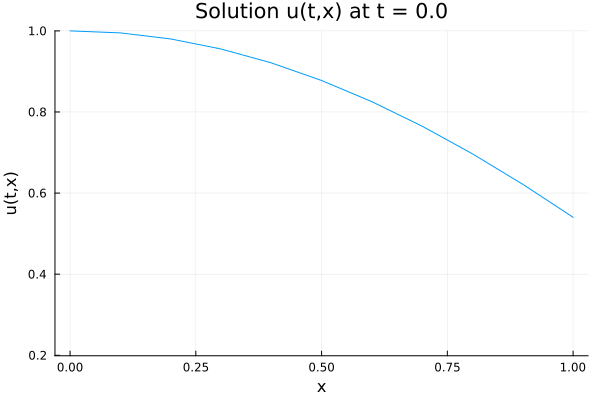

In [39]:
# Illustration of the solution

discrete_x = sol[x]
discrete_t = sol[t]
solu = sol[u(t, x)]

# Create GIF: one frame per time step
anim = @animate for i in 1:length(discrete_t)
    plot(
        discrete_x,
        solu[i, :],
        xlabel = "x",
        ylabel = "u(t,x)",
        title = "Solution u(t,x) at t = $(round(discrete_t[i], digits=2))",
        legend = false,
        ylim = (minimum(solu), maximum(solu)),
        size = (600, 400),
        label = "Numerical solution",
    )
end
gif(anim, "../plots/heat_equation_solution.gif", fps=2)

# Physics-informed regression
We proceed to show two approaches of estimating the thermal diffusivity $\alpha$ from data:
1. **Discrete differential calculus**: We use finite differences to estimate the second spatial derivative of the temperature field. The thermal diffusivity $\alpha$ is then estimated by minimizing the residual of the heat equation.
2. **Symbolic discretization**: We use the method of lines to discretize the heat equation and then use the resulting ODE system to estimate the thermal diffusivity $\alpha$ by minimizing the residual of the ODE system.



### PIR with discrete differential calculus
The package `PhysicsInformedRegression.jl` approximates both spatial and temporal derivatives first and second order derivatives using central differences.
for observations of the temperature field $u(t,x)$ at a set of points $(t_i, x_j)$, the first and second derivatives are approximated as follows:
$$
\begin{align*}
\frac{\partial u}{\partial t} &\approx \frac{u(t_{i+1}, x_j) - u(t_{i-1}, x_j)}{2\Delta t} \\
\frac{\partial^2 u}{\partial x^2} &\approx \frac{u(t_i, x_{j+1}) - 2u(t_i, x_j) + u(t_i, x_{j-1})}{(\Delta x)^2}
\end{align*}
$$ 
Where $\Delta t$ and $\Delta x$ are the time and space step sizes, respectively. The approximations of the moments are compared against their analytical counterparts.

In [ ]:
sample = CartesianIndex(5,5) #use middle of the grid as sample point
ivs = [t, x]
dvs = [u(t, x)]

observations = PhysicsInformedRegression.Observations(
    [sample],
    ivs,
    dvs,
    sol
) # finite difference data structure
test_observation = observations[sample]
#compare approximations with exact values
println("Observation at $(test_observation.coordinate) with ivs $(test_observation.iv_values)")
println("Exact value: $(u_exact(test_observation.iv_values...)) vs numerical solution: $(test_observation.dv_values)") 
# approximate derivatives
println("Exact jacobian: $(du_exact(test_observation.iv_values...))")
println("Approximated jacobian: $(test_observation.jacobian)")
# approximate Hessian
println("Exact Hessian: $(ddu_exact(test_observation.iv_values...))")
println("Approximated Hessian: $(test_observation.hessian)")

Observation at CartesianIndex(5, 5) with ivs [0.4, 0.4]
Exact value: 0.6174056479016456 vs numerical solution: [0.6172906694236305]
Exact jacobian: [-0.6174056479016456, -0.261034921143457]
Approximated jacobian: [-0.6191191332837603 -0.2603779854747501]
Exact Hessian: [0.6174056479016456, 0.261034921143457, 0.261034921143457, -0.6174056479016456]
Approximated Hessian: [0.6313008918044588 0.2616505236230249;;; 0.2616505236230249 -0.6142094836556341]


### PIR equations

In [64]:
# Setup model for regression
using Latexify
using LaTeXStrings

A,b = PhysicsInformedRegression.setup_linear_system(pdesys)
A_sym = latexify(A)
b_sym = latexify(b)
display(L"A = %$A_sym")
display(L"b = %$b_sym")

L"$A = \begin{equation}
\left[
\begin{array}{c}
\frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) \\
\end{array}
\right]
\end{equation}
$"

L"$b = \begin{equation}
\left[
\begin{array}{c}
\frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) \\
\end{array}
\right]
\end{equation}
$"

The heat equation is rewritten as a linear system of equations in terms of $\alpha$ as :
$$
\begin{align*}
    A \cdot \alpha = b\\
    \frac{\partial^2 u}{\partial x^2} \alpha  = \frac{\partial u}{\partial t}
\end{align*}
$$
where $A$ is the matrix of parameters and $b$ is the right-hand side vector. The goal is to find the parameters that minimize the residuals of the system, which can be formulated as a least squares problem. 
$$
\begin{align*}
    \alpha^* &= \min_{\alpha} \| A \cdot \alpha - b \|^2\\
    &= (A^T A)^{-1} A^T b
\end{align*}
$$
Where $\alpha^*$ is the estimated thermal diffusivity and $\| \cdot \|$ denotes the Euclidean norm. $A$ and $b$ are evaluated and vertically concatenated for all spatiotemporal observations in the dataset.

In [59]:
λ = 0 # regularization parameter
paramsest = physics_informed_regression(pdesys, sol; lambda = λ)
# Compare the estimated parameters to the true parameters
for (i, param) in enumerate(parameters(pdesys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
    #relative error
    rel_error = abs((paramsest[param] - parameterdict[param]) / parameterdict[param])
    println("Relative error: $(rel_error)")
end


Parameter α = 1.0 estimated as 1.084949488358282
Relative error: 0.08494948835828198


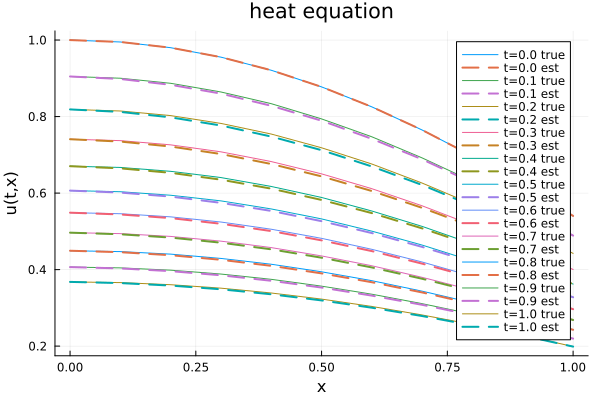

In [36]:
#### simulate retrieved parameters
@named pdesys_retrieved = PDESystem(eq, bcs, domains, [t, x], [u(t, x)], [α]; defaults = paramsest)

# Convert the PDE problem into an ODE problem
prob_est = discretize(pdesys_retrieved,discretization)

# Solve ODE problem
sol_est = solve(prob_est, Tsit5(), saveat=dt)

plt = plot()

for i in eachindex(sol[t])
    plot!(sol[t], sol[u(t,x)][i, :], label="t=$(discrete_t[i]) true")
    plot!(sol_est[t], sol_est[u(t,x)][i, :], label="t=$(discrete_t[i]) est", ls=:dash, lw=2)
    plot!(xlabel="x", ylabel="u(t,x)", title="heat equation", legend=:topright)
end
plt

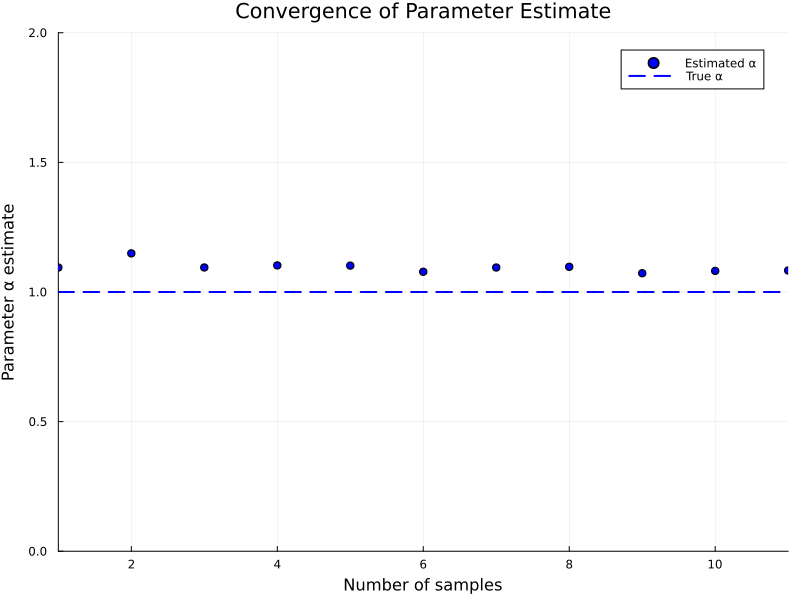

In [101]:
using Random
Nt, Nx = size(sol[u(t,x)])
parameter_ests = zeros(Nx)
Random.seed!(3) #for reproducibility

for Ns in 1:Nx
    x_samples, t_samples = rand(1:Nx, Ns), collect(1:Nt) #sample time steps (1 to N) and random space points (1 to Nx)
    samples = vcat([CartesianIndex.(x_samples, t*ones(Int, Ns)) for t in t_samples]...)
    parameter_ests[Ns] = physics_informed_regression(pdesys, sol; lambda = λ, samples = samples)[α]
end

#plot the convergence of the parameter estimate
scatter(1:Nx, parameter_ests, label="Estimated α", xlabel="Number of samples", ylabel="Parameter α estimate", title="Convergence of Parameter Estimate", xlim=(1, Nx), ylim=(0, 2), 
    legend=:topright, size=(800, 600), markershape=:circle, markercolor=:blue, markersize=4)
plot!([1, Nx], [parameterdict[α], parameterdict[α]], label="True α", linestyle=:dash, color=:blue, linewidth=2)

## PIR with symbolic discretization
The package `PhysicsInformedRegression.jl` in conjunction with [Symbolic Discretization](https://docs.sciml.ai/MethodOfLines/stable/api/discretization/) can also be used to estimate the thermal diffusivity $\alpha$ by discretizing the heat equation using the method of lines. In this case, we define the ODE system corresponding to the discretized heat equation and use it to estimate $\alpha$.

In [49]:
### Symbolic discretization
pde_discretization, timeinterval = symbolic_discretize(pdesys, discretization)
pde_discretization

Model pdesys:
Equations (11):
  11 standard: see equations(pdesys)
Unknowns (11): see unknowns(pdesys)
  (u(t))[1] [defaults to 1.0]
  (u(t))[2] [defaults to 0.995004]
  (u(t))[3] [defaults to 0.980067]
  (u(t))[4] [defaults to 0.955336]
  ⋮
Parameters (1): see parameters(pdesys)
  α [defaults to 1.0]

In [73]:
using Latexify
A,b = PhysicsInformedRegression.setup_linear_system(pde_discretization)
println("Symbolic discretization:")
println("A = $A")
println("b = $b")
# Estimate parameters using symbolic discretization

Symbolic discretization:
A = Any[99.99999999999999((u(t))[1] + (u(t))[3]) - 199.99999999999997(u(t))[2]; 99.99999999999999((u(t))[2] + (u(t))[4]) - 199.99999999999997(u(t))[3]; 99.99999999999999(u(t))[3] - 199.99999999999997(u(t))[4] + 99.99999999999999(u(t))[5]; 99.99999999999999((u(t))[4] + (u(t))[6]) - 199.99999999999997(u(t))[5]; 99.99999999999999(u(t))[5] - 199.99999999999997(u(t))[6] + 99.99999999999999(u(t))[7]; 99.99999999999999(u(t))[6] - 199.99999999999997(u(t))[7] + 99.99999999999999(u(t))[8]; 99.99999999999999((u(t))[7] + (u(t))[9]) - 199.99999999999997(u(t))[8]; 99.99999999999999(u(t))[10] + 99.99999999999999(u(t))[8] - 199.99999999999997(u(t))[9]; -199.99999999999997(u(t))[10] + 99.99999999999999((u(t))[11] + (u(t))[9]); 0.0; 0.0;;]
b = Any[Differential(t)((u(t))[2]), Differential(t)((u(t))[3]), Differential(t)((u(t))[4]), Differential(t)((u(t))[5]), Differential(t)((u(t))[6]), Differential(t)((u(t))[7]), Differential(t)((u(t))[8]), Differential(t)((u(t))[9]), Differentia

Where
$$
\begin{equation}
A = 
\left[
\begin{array}{c}
100 \left( u_{{1}}\left( t \right) + u_{{3}}\left( t \right) \right) - 200u_{{2}}\left( t \right) \\
100 \left( u_{{2}}\left( t \right) + u_{{4}}\left( t \right) \right) - 200u_{{3}}\left( t \right) \\
100 u_{{3}}\left( t \right) - 200u_{{4}}\left( t \right) + 100 u_{{5}}\left( t \right) \\
100 \left( u_{{4}}\left( t \right) + u_{{6}}\left( t \right) \right) - 200u_{{5}}\left( t \right) \\
100 u_{{5}}\left( t \right) - 200u_{{6}}\left( t \right) + 100 u_{{7}}\left( t \right) \\
100 u_{{6}}\left( t \right) - 200u_{{7}}\left( t \right) + 100 u_{{8}}\left( t \right) \\
100 \left( u_{{7}}\left( t \right) + u_{{9}}\left( t \right) \right) - 200u_{{8}}\left( t \right) \\
100 u_{{10}}\left( t \right) + 100 u_{{8}}\left( t \right) - 200u_{{9}}\left( t \right) \\
 - 200u_{{10}}\left( t \right) + 100 \left( u_{{11}}\left( t \right) + u_{{9}}\left( t \right) \right) \\
0.0 \\
0.0 \\
\end{array}
\right]
\end{equation}
$$
and 
$$
\begin{equation}
b = 
\left[
\begin{array}{c}
\frac{\mathrm{d} u_{{2}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{3}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{4}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{5}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{6}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{7}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{8}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{9}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} u_{{10}}\left( t \right)}{\mathrm{d}t} \\
u_{{1}}\left( t \right) - e^{ - t} \\
u_{{11}}\left( t \right) - 0.5403023058681398 e^{ - t} \\
\end{array}
\right]
\end{equation}
$$

where $A$ is the matrix of parameters and $b$ is the right-hand side vector. The goal is to find the parameters that minimize the residuals of the system, which can be formulated as a least squares problem. 
$$
\begin{align*}
    \alpha^* &= \min_{\alpha} \| A \cdot \alpha - b \|^2\\
    &= (A^T A)^{-1} A^T b
\end{align*}
$$
Where $\alpha^*$ is the estimated thermal diffusivity and $\| \cdot \|$ denotes the Euclidean norm. $A$ and $b$ are evaluated and vertically concatenated for all temporal observations in the dataset.

In [ ]:
### Using PIR as an ODE regression problem
du_dt_approx = PhysicsInformedRegression.finite_diff(sol[u(t,x)], sol[t])
du_dt_approx = [du_dt_approx[i, :] for i in eachindex(sol[t])]
solu = [sol[u(t, x)][i, :] for i in eachindex(sol[t])]
paramsest = physics_informed_regression(pde_discretization, solu, du_dt_approx; tvals = sol[t])


# Compare the estimated parameters to the true parameters
for (i, param) in enumerate(parameters(pdesys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
    #relative error
    rel_error = abs((paramsest[param] - parameterdict[param]) / parameterdict[param])
    println("Relative error: $(rel_error)")
end

Parameter α = 1.0 estimated as 0.988979760769216
Relative error: 0.01102023923078399
